# CBS Week 8 Assessment: Bayesian Concept Learning
## Semester 2 2023

In [2]:
suppressPackageStartupMessages({
    library(tidyverse)
    library(testthat)
    library(knitr)
    library(kableExtra)
    library(IRdisplay)  
})

options(repr.plot.width=16, repr.plot.height=8)

# a function for displaying tables
show_table <- function(d) {
    kable(d, "html", align="c")  %>% 
        as.character()  %>% 
        display_html()
}

This notebook is due on September 22. Please make sure that your notebook validates before you submit it --- if your notebook doesn't validate the automated grader may run into issues.

This notebook will explore a simple version of Josh Tenenbaum's number game. The number game was covered in class this week, and is also described by the Murphy reading available on Canvas. In class we discussed a version of the number game that considered integers between 1 and 100. Here we'll make things even simpler and will consider only integers between 1 and 12.


The number game involves inferences about a concept $C$. For example, if $C$ is the concept "even numbers", the extension of $C$ would be $\{2,4,6,8,10,12\}$. If $C$ is the concept "numbers between 4 and 6", then the extension would be $\{4,5,6\}$.  

### Question 1 (1 point)

Given that we are working with integers from 1 to 12 (inclusive), how many different extensions of concept $C$ are possible? Explain your answer.

=== BEGIN MARK SCHEME ===

When specifying an extension there are 2 choices to make about each integer from 1 to 12 -- is it included or not? The number of extensions is therefore
$2^{12} = 4096$. 

Here we've included the extension that corresponds to the empty set. It's probably best to drop this, leaving 4095 extensions. But full credit to anyone who gives 4096 as the answer.

=== END MARK SCHEME ===

## Hypothesis space $\mathcal{H}$ and priors $p(h)$

As for last week's tutorial notebook, we'll use a tabular approach to Bayesian inference. We'll construct a data frame where each row corresponds to a hypothesis about the extension of concept $C$, and where priors and likelihood functions are stored in columns. We're going to consider four different priors and two different likelihood functions (strong and weak sampling). Combining these priors and likelihood functions produces a total of 8 different Bayesian models.

Let's start by setting up the hypothesis space $\mathcal{H}$ and the priors. Provided that you understand how the priors are defined, the code for setting up these priors is not that important for our purposes, so feel free to skim it.

First we define two helper functions:

In [3]:
# A helper function that sets bits in H_VEC (a 12 element vector) corresponding to H_MEMBERS, a set of 
# concept members 

set_member_indices <- function(h_vec, h_members) {
  h_vec[h_members] <- 1
  return(h_vec)
}

# ... and a helper function that converts a H_VEC to a string
indices_to_str<- function(h_vec) {
  paste0(which(h_vec==1), collapse="/")
}

Now define `h_math`, a hypothesis space including 8 mathematical concepts and a uniform prior (`prior_math`) over this hypothesis space. Eight mathematical concepts will be enough for our purposes but others could be included (e.g. "powers of 2", or "cube numbers").

In [4]:
n <- 12
zeros <- replicate(n, 0)
h_math <-
  tibble(h_members = list(
    c(1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12),   # all numbers
    c(2, 4, 6, 8, 10, 12),   # even numbers
    c(1, 3, 5, 7, 9, 11),    # odd numbers
    c(3, 6, 9, 12),          # multiples of 3
    c(4, 8, 12),             # multiples of 4
    c(5, 10),                # multiples of 5
    c(6, 12),                # multiples of 6
    c(1, 4, 9)               # square numbers
  ),
  prior_math = 1) %>%
  mutate(h_vec = map(h_members, ~set_member_indices(zeros, .x))) %>% 
  mutate(prior_math= prior_math/sum(prior_math)) %>% 
  mutate(h_str= map_chr(h_vec, indices_to_str)) %>% 
  select(h_str, prior_math) 

show_table(head(h_math))

h_str,prior_math
1/2/3/4/5/6/7/8/9/10/11/12,0.125
2/4/6/8/10/12,0.125
1/3/5/7/9/11,0.125
3/6/9/12,0.125
4/8/12,0.125
5/10,0.125


Next we'll define `h_interval`, a hypothesis space of interval concepts (e.g. "numbers between 2 and 5", "numbers between 6 and 12").

In [5]:
# enumerate all pairs (l, r) where l is less than r
pairs <- t(combn(1:n, 2)) 
colnames(pairs) <- c("left", "right")

# a helper function that sets bits in H_VEC that include all numbers from LEFT to RIGHT 
pair_to_indices <- function(h_vec, left, right) {
  h_vec[left:right] <- 1
  return(h_vec)
}

h_interval <- tibble(left = 1:n, right = 1:n) %>% 
  bind_rows(as_tibble(pairs)) %>% 
  mutate(prior_interval = 1, h_vec = map2(left, right, ~pair_to_indices(zeros, .x, .y)))  %>% 
  mutate(prior_interval = prior_interval /sum(prior_interval)) %>% 
  mutate(h_str= map_chr(h_vec, indices_to_str)) %>% 
  select(h_str, prior_interval)

# look at the last 5 hypotheses
show_table(tail(h_interval, 5))

h_str,prior_interval
9/10/11,0.0128205
9/10/11/12,0.0128205
10/11,0.0128205
10/11/12,0.0128205
11/12,0.0128205


Finally, we'll set up a hypothesis space `h_all` that includes all possible extensions of concept $C$ along with a uniform prior `h_uniform` over this space. The complete set of hypotheses in `h_all` is the hypothesis space $\mathcal{H}$ we'll be using for subsequent analyses.

In [6]:
h_all <-  expand.grid(replicate(n, 0:1, simplify = FALSE))
colnames(h_all) <- paste("V", 1:n, sep="")
# drop the empty hypothesis
h_all <- h_all[-1,]
h_all <- tibble(h_all) %>% 
  rowwise() %>% 
  mutate(h_vec = list(c_across(V1:V12))) %>% 
  ungroup() %>% 
  mutate(h_str= map_chr(h_vec, indices_to_str)) %>%
  mutate(prior_uniform = 1)  %>% 
  mutate(prior_uniform = 1/sum(prior_uniform)) 

# look at the first 5 hypotheses. You'll see some additional columns V1:V12 and h_list that will be used later for
# computing likelihood functions and model generalizations. Column V1 indicates whether or not 1 belongs to the 
# concept, and similarly for V2 through V12. h_vec is a vector indicating which numbers belong to the concept.
show_table(head(h_all, 5))

V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,h_vec,h_str,prior_uniform
1,0,0,0,0,0,0,0,0,0,0,0,"1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0",1,0.0002442
0,1,0,0,0,0,0,0,0,0,0,0,"0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0",2,0.0002442
1,1,0,0,0,0,0,0,0,0,0,0,"1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0",1/2,0.0002442
0,0,1,0,0,0,0,0,0,0,0,0,"0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0",3,0.0002442
1,0,1,0,0,0,0,0,0,0,0,0,"1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0",1/3,0.0002442


Now we'll combine `h_math`, `h_interval` and `h_all` to specify a single table `h` that specifies the entire hypothesis space $\mathcal{H}$ along with four prior distributions. `prior_math` assigns nonzero probability only to the hypotheses in `h_math`, `prior_interval` assigns nonzero probability only to the hypotheses in `h_interval`, and `prior_uniform` assigns uniform probability to all possible hypotheses. The final prior `prior_combo` is a "combination prior" defined as the average of the three other priors.

In [7]:
h <- h_all %>% 
  left_join(h_math, by = "h_str") %>% 
  left_join(h_interval, by = "h_str") %>% 
  replace_na(list(prior_math = 0, prior_interval = 0)) %>% 
  mutate(prior_combo = (prior_math + prior_interval + prior_uniform) / 3 )

show_table(head(h, 5))

V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,h_vec,h_str,prior_uniform,prior_math,prior_interval,prior_combo
1,0,0,0,0,0,0,0,0,0,0,0,"1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0",1,0.0002442,0,0.0128205,0.0043549
0,1,0,0,0,0,0,0,0,0,0,0,"0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0",2,0.0002442,0,0.0128205,0.0043549
1,1,0,0,0,0,0,0,0,0,0,0,"1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0",1/2,0.0002442,0,0.0128205,0.0043549
0,0,1,0,0,0,0,0,0,0,0,0,"0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0",3,0.0002442,0,0.0128205,0.0043549
1,0,1,0,0,0,0,0,0,0,0,0,"1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0",1/3,0.0002442,0,0.0000000,0.0000814


## Likelihood function $p(X|h)$
We're ready to define the likelihood function. Following the notation in the Murphy reading, let $X$ be a list of positive examples of the concept. For instance, if we are told that 4 and 8 belong to the concept, then $X$ would be the list $[4, 8]$. The likelihood function $P(X|h)$ specifies the probability of observing $X$ given that the true concept is captured by hypothesis $h$.

We'll consider two likelihood functions. *Strong sampling* assumes that the observations in $X$ are randomly sampled from the set of all positive examples of the concept, which means that $p(X|h) = \left[ \frac{1}{|h|} \right]^n$, where $|h|$ is the size of hypothesis $h$. 

*Weak sampling* assumes that the examples were chosen by some process independent of $h$ and subsequently labeled as positive (i.e. members of the concept) or negative (not members of the concept). Under weak sampling it is possible to observe negative examples, but we're only going to consider cases in which all examples happen to be positive. Weak sampling corresponds to the likelihood function $p(X|h) = 1$ if all observations in $X$ are consistent with $h$, and 0 otherwise.

### Question 2 (1  point)
The code below sets up the likelihood function, but the definition of strong sampling is incorrect. Fix the code so that strong sampling is defined correctly.

In [8]:
# H_VEC is a binary vector indicating which numbers belong to the concept, and X is a set of positive examples
# ltype is a flag indicating whether we're assuming "strong" or "weak" sampling
likelihood_fn <- function(h_vec, X, ltype) {
  n <- length(X)
  h_size <- sum(h_vec)
  if ( sum(h_vec[X]) < n ) {
    l <- 0
  } else {
    l <- switch(ltype,
        strong = 1, # FIX THIS LINE
        weak  = 1)
  }
}

### BEGIN SOLUTION
likelihood_fn <- function(h_vec, X, ltype) {
  n <- length(X)
  h_size <- sum(h_vec)
  if ( sum(h_vec[X]) < n ) {
    l <- 0
  } else {
    l <- switch(ltype,
        strong = (1/h_size)^n,
        weak  = 1)
  }
}
### END SOLUTION

In [19]:
# we'll test likelihood_fn() by applying it to the observation set X = [3,4,5]. Make sure that
# your function passes this test before you continue!
X <- c(3,4,5)
h_like_test <- h %>% 
    mutate(weak_like   = map_dbl(h_vec, ~likelihood_fn(.x, X, "weak"))) %>%    
    mutate(strong_like = map_dbl(h_vec, ~likelihood_fn(.x, X, "strong")))  %>% 
    arrange(desc(weak_like))  %>% 
    pull(strong_like)  %>% 
    first()
expect_equal(h_like_test, 0.037037, tolerance = 0.00001)


## Computing the posterior $p(h|X) \propto p(X|h)p(h)$

We can now combine the prior and likelihood to compute the posterior distribution. The prior $p(h)$  and likelihood $p(X|h)$ will both correspond to columns in our table, and if we were mechanically following the tabular approach we could also add columns for the observation set $X$, the joint distribution $p(X,h)$, and the marginal distribution $p(X)$. The posterior could then be computed by dividing the joint distribution column $p(X,h)$ by the marginal distribution column $p(X)$.

A quicker way to compute the posterior, however, is to multiply the prior and likelihood columns elementwise (which produces the joint distribution $p(X,h)$) and to normalize the resulting column so that it sums to 1. This approach means that we don't actually have to compute the marginal distribution $p(X)$ directly --- instead we exploit the fact that the posterior $p(h|X)$ is a probability distribution and must sum to 1 over the hypothesis space.

The code below uses `map_dbl()` to apply `likelihood_fn()` to each hypothesis in `h`. Because we've defined 4 priors and 2 likelihood functions there are 8 models in total, and we'll compute a posterior distribution for each one.

In [10]:
# a function that processes a set of observations $X$ by first computing likelihoods STRONG_LIKE and WEAK_LIKE 
# according to strong and weak sampling, then combining these likelihoods with the four priors. For example, 
# WEAK_MATH is the posterior distribution for the model that assumes weak sampling and uses the mathematical 
# prior, and STRONG_COMBO is the model that assumes strong sampling and uses the combination prior
process_X <- function(h, X) {
  h_post <- h %>% 
    mutate(weak_like   = map_dbl(h_vec, ~likelihood_fn(.x, X, "weak"))) %>%    # likelihood column for weak sampling
    mutate(strong_like = map_dbl(h_vec, ~likelihood_fn(.x, X, "strong"))) %>%  # likelihood column for strong sampling
    # combine prior and likelihood 
    mutate(weak_math = weak_like * prior_math, strong_math = strong_like * prior_math, 
           weak_interval = weak_like * prior_interval, strong_interval = strong_like * prior_interval, 
           weak_uniform = weak_like * prior_uniform, strong_uniform = strong_like * prior_uniform,
           weak_combo = weak_like * prior_combo, strong_combo = strong_like * prior_combo) %>% 
    # renormalize
    mutate(weak_math = weak_math/sum(weak_math), strong_math = strong_math/sum(strong_math),
           weak_interval = weak_interval/sum(weak_interval), strong_interval = strong_interval/sum(strong_interval),
           weak_uniform = weak_uniform/sum(weak_uniform), strong_uniform = strong_uniform/sum(strong_uniform),
           weak_combo = weak_combo/sum(weak_combo), strong_combo = strong_combo/sum(strong_combo))
}

Let's now run the models. Suppose we observe that 4 and 8 belong to concept $C$ (i.e. $X = [4,8]$). We'll compute posterior distributions $p(h|X)$ for all models.

In [11]:
h_post <- process_X(h, c(4,8))  %>% 
    arrange(desc(strong_math)) # arrange hypotheses in descending order according to the posterior for the strong_math model
show_table(head(h_post, 4))

V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,h_vec,h_str,prior_uniform,prior_math,prior_interval,prior_combo,weak_like,strong_like,weak_math,strong_math,weak_interval,strong_interval,weak_uniform,strong_uniform,weak_combo,strong_combo
0,0,0,1,0,0,0,1,0,0,0,1,"0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1",4/8/12,0.0002442,0.125,0.0000000,0.0417481,1,0.1111111,0.3333333,0.7619048,0.00,0.0000000,0.0009766,0.0044001,0.1420854,0.4878417
0,1,0,1,0,1,0,1,0,1,0,1,"0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1",2/4/6/8/10/12,0.0002442,0.125,0.0000000,0.0417481,1,0.0277778,0.3333333,0.1904762,0.00,0.0000000,0.0009766,0.0011000,0.1420854,0.1219604
1,1,1,1,1,1,1,1,1,1,1,1,"1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1",1/2/3/4/5/6/7/8/9/10/11/12,0.0002442,0.125,0.0128205,0.0460216,1,0.0069444,0.3333333,0.0476190,0.05,0.0215575,0.0009766,0.0002750,0.1566298,0.0336112
1,0,0,0,0,0,0,0,0,0,0,0,"1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0",1,0.0002442,0.000,0.0128205,0.0043549,0,0.0000000,0.0000000,0.0000000,0.00,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000


### Question 3 (1 point)

Find the column `strong_math`, which shows the posterior $p(h|X)$ according to the `strong_math` model (strong sampling and mathematical prior). You should see that only three hypotheses have non-zero posterior probability according to this model -- what are the three hypotheses?

=== BEGIN MARK SCHEME ===

The three hypotheses are "multiples of 4", "even numbers" and "all numbers"

=== END MARK SCHEME ===

### Question 4 (1 point)

The observation set $X = [4,8]$ is equally consistent with "multiples of 4" and "even numbers", yet after observing $X$ you should see that the `strong_math` model thinks that "multiples of 4" is much more likely than "even numbers." Explain why the model makes this inference.

=== BEGIN MARK SCHEME ===

The strong_math model makes this prediction because it assumes strong sampling. Even though "multiples of 4" and "even numbers" are both consistent with $X$, "multiples of 4" is a smaller concept than "even numbers." As a result, strong sampling assigns a higher likelihood to "multiples of 4" than to "even numbers"

=== END MARK SCHEME ===

In [12]:
# Use this cell to inspect h_post in various ways

To answer the next two questions, please use the `arrange()` function to sort `h_post` in different ways. You can use the code cell above to try out different sortings.

### Question 5 (1 point)

What is the hypothesis with greatest posterior probability according to the `strong_interval` model (ie the model that assumes strong sampling and uses the interval-based prior)? Explain why the `strong_interval` model makes this inference.

=== BEGIN MARK SCHEME ===

The most probable hypothesis according to the `strong_interval` model is the hypothesis that includes all numbers from 4 to 8 inclusive. The model favours this hypothesis because it corresponds to the smallest possible interval that includes both 4 and 8, and strong sampling produces a preference for small hypotheses.

=== END MARK SCHEME ===

### Question 6 (1 point)

What is the hypothesis with greatest posterior probability according to the `strong_uniform` model (ie the model that assumes strong sampling and uses a uniform prior over the entire hypothesis space)? Explain why the `strong_uniform` model makes this inference.

=== BEGIN MARK SCHEME ===

The most probable hypothesis according to the `strong_uniform` model is the hypothesis that includes only 4 and 8. The model favours this hypothesis because it is the smallest possible hypothesis that includes both 4 and 8, and strong sampling produces a preference for small hypotheses.

=== END MARK SCHEME ===

## Posterior predictive distribution $P(y \in C | X)$

We've looked at the posterior distributions assigned by the models to individual hypotheses. Let's now look at how the models generalize across the full set of numbers. We'll compute and plot the posterior predictive distribution $P(y \in C | X)$, which shows the probability that number $y$ belongs to concept $C$ after observing the examples in $X$. Because "posterior predictive" is a mouthful, we'll often refer to the "predictive" distribution for short.

The predictive distribution can be computed by summing over the entire hypothesis space $\mathcal{H}$: \begin{align}
P(y \in C | X) &= \sum_{h \in \mathcal{H}} P(y \in C | h)P(h|X)  &(1)\\
               &= \sum_{h \in \mathcal{H_y}}P(h|X), & (2)
\end{align}
where $\mathcal{H_y}$ is the set of all hypotheses that include $y$.

For example, after observing $X = [4,8]$ the `strong_math` model computes a posterior distribution over all hypotheses $h \in \mathcal{H}$. The probability that 12 also belongs to the concept corresponds to the sum of the posterior probabilities assigned to all hypotheses that include 12.

In [13]:
# Compute the predictive distribution across all numbers from 1 to 12
posterior_predictive <- function(h_post) {
    
  # we'll compute Equation 2 using matrix multiplication.
  # h_mat is a binary matrix where the 12 rows represent the numbers from 1 to 12, and column i indicates which
  # numbers belong to hypothesis i
  h_mat <- h_post %>% 
    select(V1:V12) %>% 
    as.matrix() %>% 
    t()
  
  # the posterior predictive distribution for each model is now computed by multiplying h_mat by the posterior
  # distribution for that model
  
  p_pred <- tibble(number  = 1:12, 
                   weak_math = as.vector(h_mat %*% h_post$weak_math),
                   strong_math = as.vector(h_mat %*% h_post$strong_math),
                   weak_interval = as.vector(h_mat %*% h_post$weak_interval),
                   strong_interval = as.vector(h_mat %*% h_post$strong_interval),
                   weak_uniform = as.vector(h_mat %*% h_post$weak_uniform),
                   strong_uniform = as.vector(h_mat %*% h_post$strong_uniform),
                   weak_combo = as.vector(h_mat %*% h_post$weak_combo),
                   strong_combo = as.vector(h_mat %*% h_post$strong_combo),
                   ) 
}

We'll also need a function to visualize the predictive distributions

In [14]:
# code to plot the posterior predictive distributions for all 8 models given the observations in X
plot_posterior_predictive <- function(p_pred, X) {
  p_pred_long <- p_pred %>% 
    pivot_longer(cols = c("weak_math", "strong_math", "weak_interval", "strong_interval", "weak_uniform", "strong_uniform", "weak_combo", "strong_combo"),
                 names_to = "model",
                 values_to = "generalization") %>% 
    separate(model, c("likelihood", "prior")) %>% 
    mutate(prior = factor(prior, levels = c("math", "interval", "uniform", "combo")))
  
  pic <- p_pred_long %>%
      ggplot(aes(x = number, y = generalization)) +
      geom_col() +
      scale_x_continuous(breaks=1:12) +  
      facet_grid(likelihood ~prior) +
      xlab("number") +
      ylab(paste("generalization after X =", paste(X, collapse=" ") ))

  plot(pic)
}

Finally, let's define a wrapper function called `number_game` that takes an observation list $X$ as input, computes posterior distributions for all models and then plots predictive distributions for all models. We'll try it out by plotting predictive distributions for the observation list $X =[4,8]$

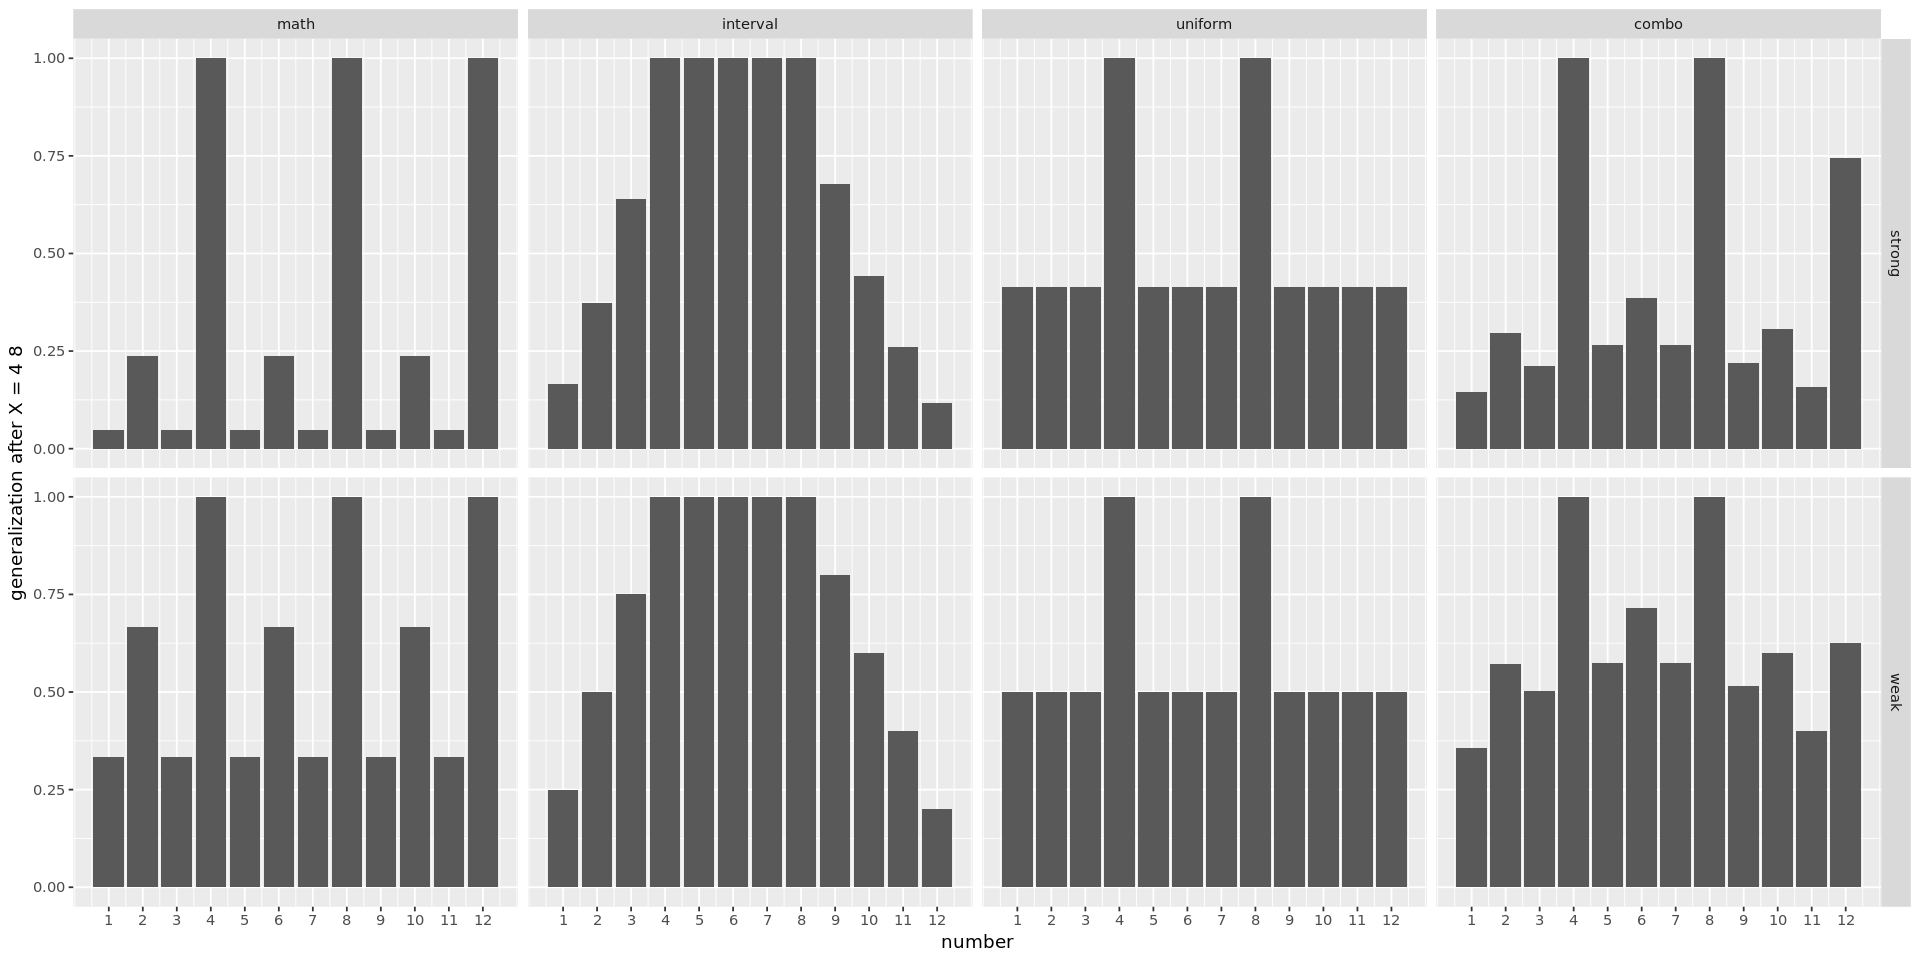

In [15]:
number_game <- function(h, X) {
  h_post <- process_X(h, X)
  p_pred <- posterior_predictive(h_post)
  plot_posterior_predictive(p_pred, X)
  return(h_post)
}

h_post <- number_game(h, c(4,8))

In the plot above, the first row shows inferences made by the four models that assume strong sampling, and the bottom row is for models that assume weak sampling. The four columns show inferences made by models that use the four different priors (mathematical, interval, uniform, and combination).

Let's change the observation set $X$ and see what happens when $X = [4,7]$.

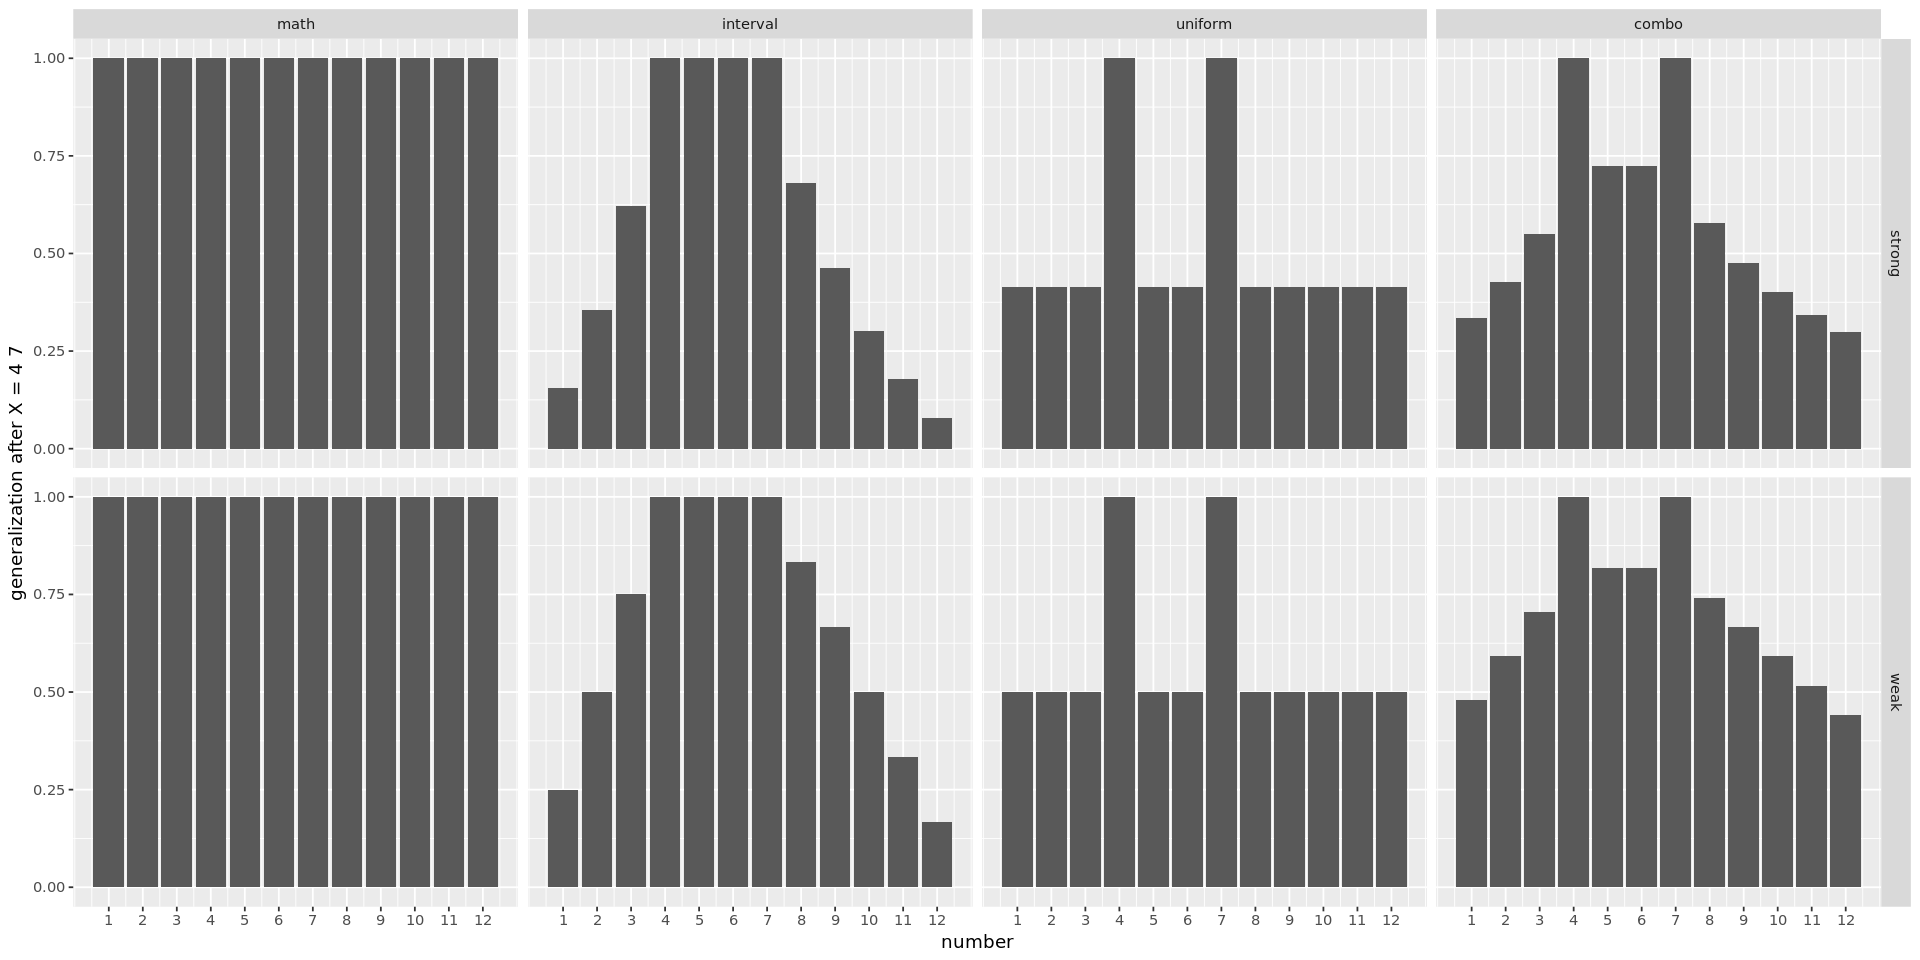

In [16]:
h_post <- number_game(h, c(4,7))

### Question 7 (1 point)

After observing $X = [4,7]$, the two models which use the mathematical prior (leftmost column) are now certain that *all* numbers belong to the concept. Why do these models make this inference?

=== BEGIN MARK SCHEME ===

These models make this inference because the mathematical prior (as defined in this notebook) assigns nonzero probability to only one hypothesis that includes both 4 and 7 -- and that hypothesis includes all of the numbers between 1 and 12

=== END MARK SCHEME ===

### Question 8 (1 point)

You should see that the two models which use the uniform prior (third column) are unable to generalize beyond the observed examples. These models are able to "memorize" the observed examples (ie they pick up on the fact that 4 and 7 belong to the concept), but they don't make any distinctions at all between numbers outside of $X$. For these two models, why is the predictive distribution completely flat across all numbers that do not belong to $X$?

=== BEGIN MARK SCHEME ===

Pick any number outside $X$ -- e.g. 11. The uniform prior does not capture any special relationship between 11 and the numbers in $X$. For each hypothesis that includes both 11 and $X$, there is another hypothesis that is identical except that it does not include 11, and the uniform prior assigns equal probability to both of these hypotheses. As a result, observing $X$ provides little information about whether 11 belongs to the concept.

11 was just an arbitrary choice, and the same logic applies to any other number outside $X$. So the models that use the uniform prior end up treating all numbers outside $X$ in the same way, which produces a predictive distribution that is flat outside of the observed examples.

=== END MARK SCHEME ===

Let's look at a case where $X$ includes a single example only.

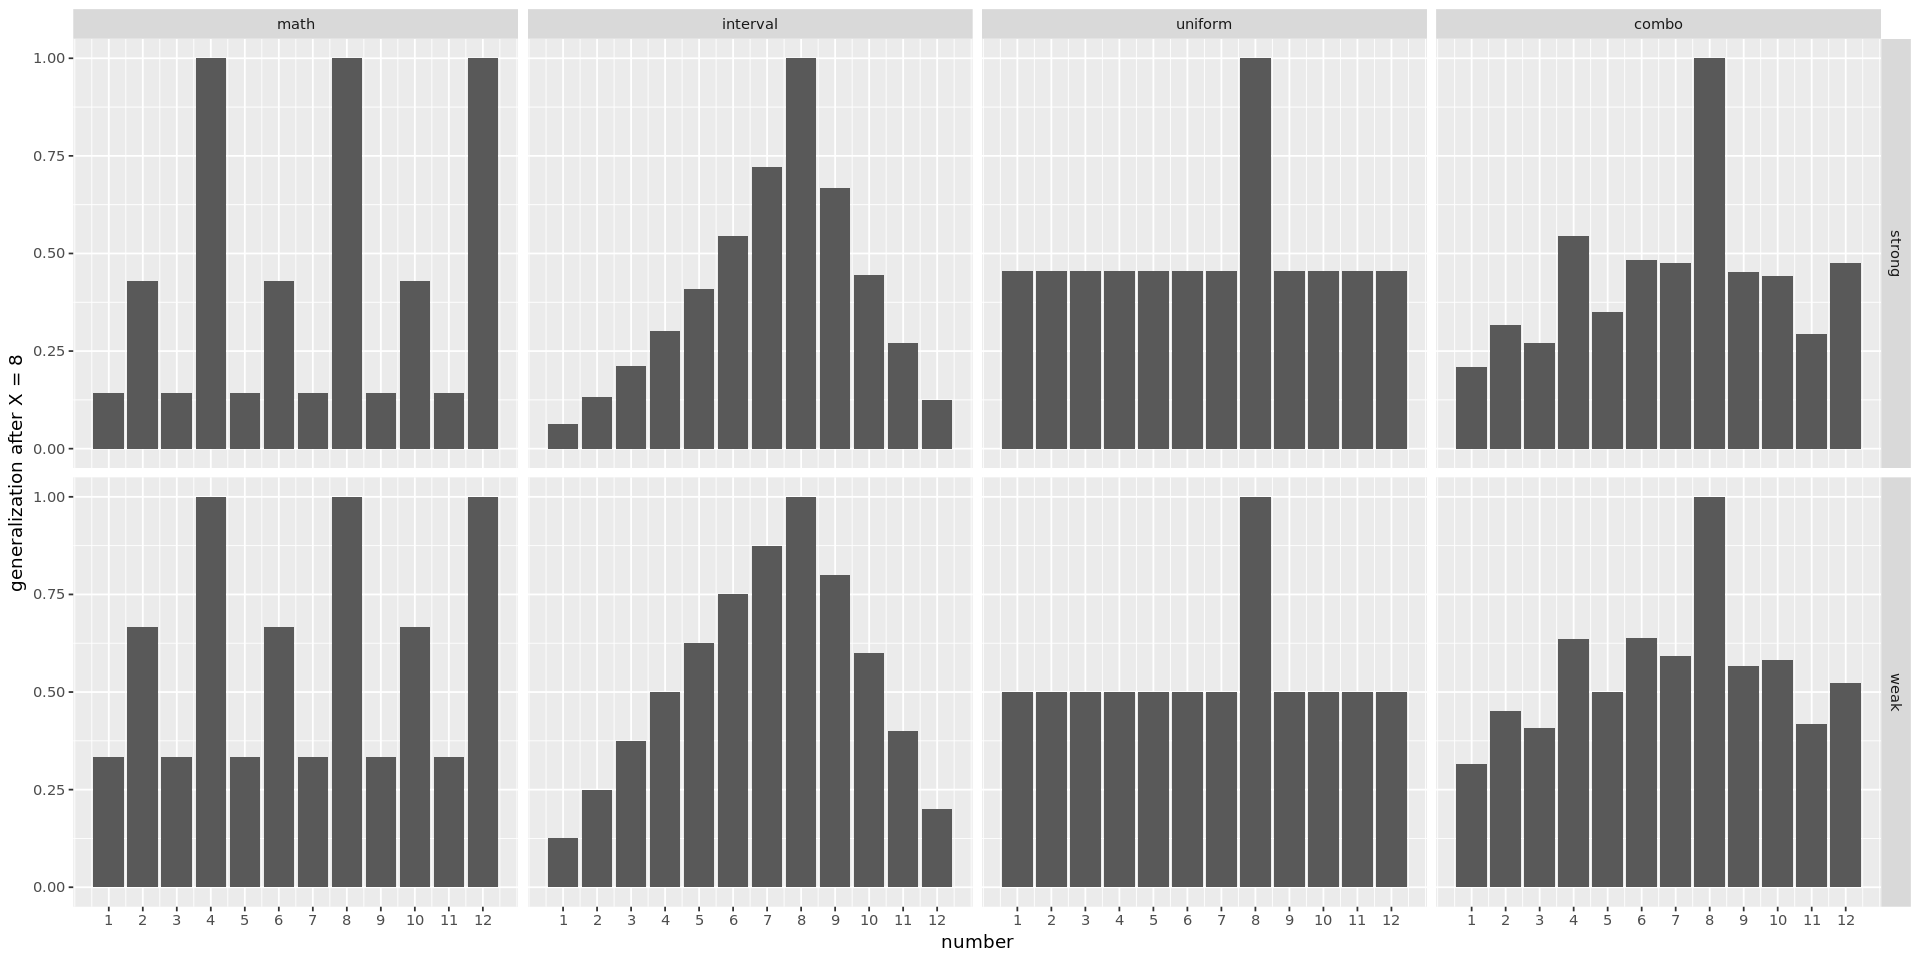

In [17]:
h_post <- number_game(h, c(8))

### Question 9 (1 point)

Consider the predictions of the models with the `interval` prior (second column). Why is the predictive distribution asymmetric around the observed example 8: in particular, why does the predictive distribution assign higher probability to 7 than to 9?

=== BEGIN MARK SCHEME ===

This happens because across our small set of numbers (1 through 12), there are more intervals that include 7 and 8 than there are intervals that include 8 and 9. For example, the interval that includes 1 through 8 has no counterpart in our hypothesis space (the interval that includes 8 through 15 is not included because it "falls off" the end of the set of numbers that we're considering). 

If we expanded the set of numbers (e.g. to numbers between 1 and 100), this kind of asymmetry would be less pronounced but there would still be asymmetries towards the edges of the expanded set. You might like to think about whether it's possible to define a model that works with the complete (ie countably infinite) set of integers!

=== END MARK SCHEME ===

Now compare the plot we just made with the plot for the case when the same positive example is observed 5 times

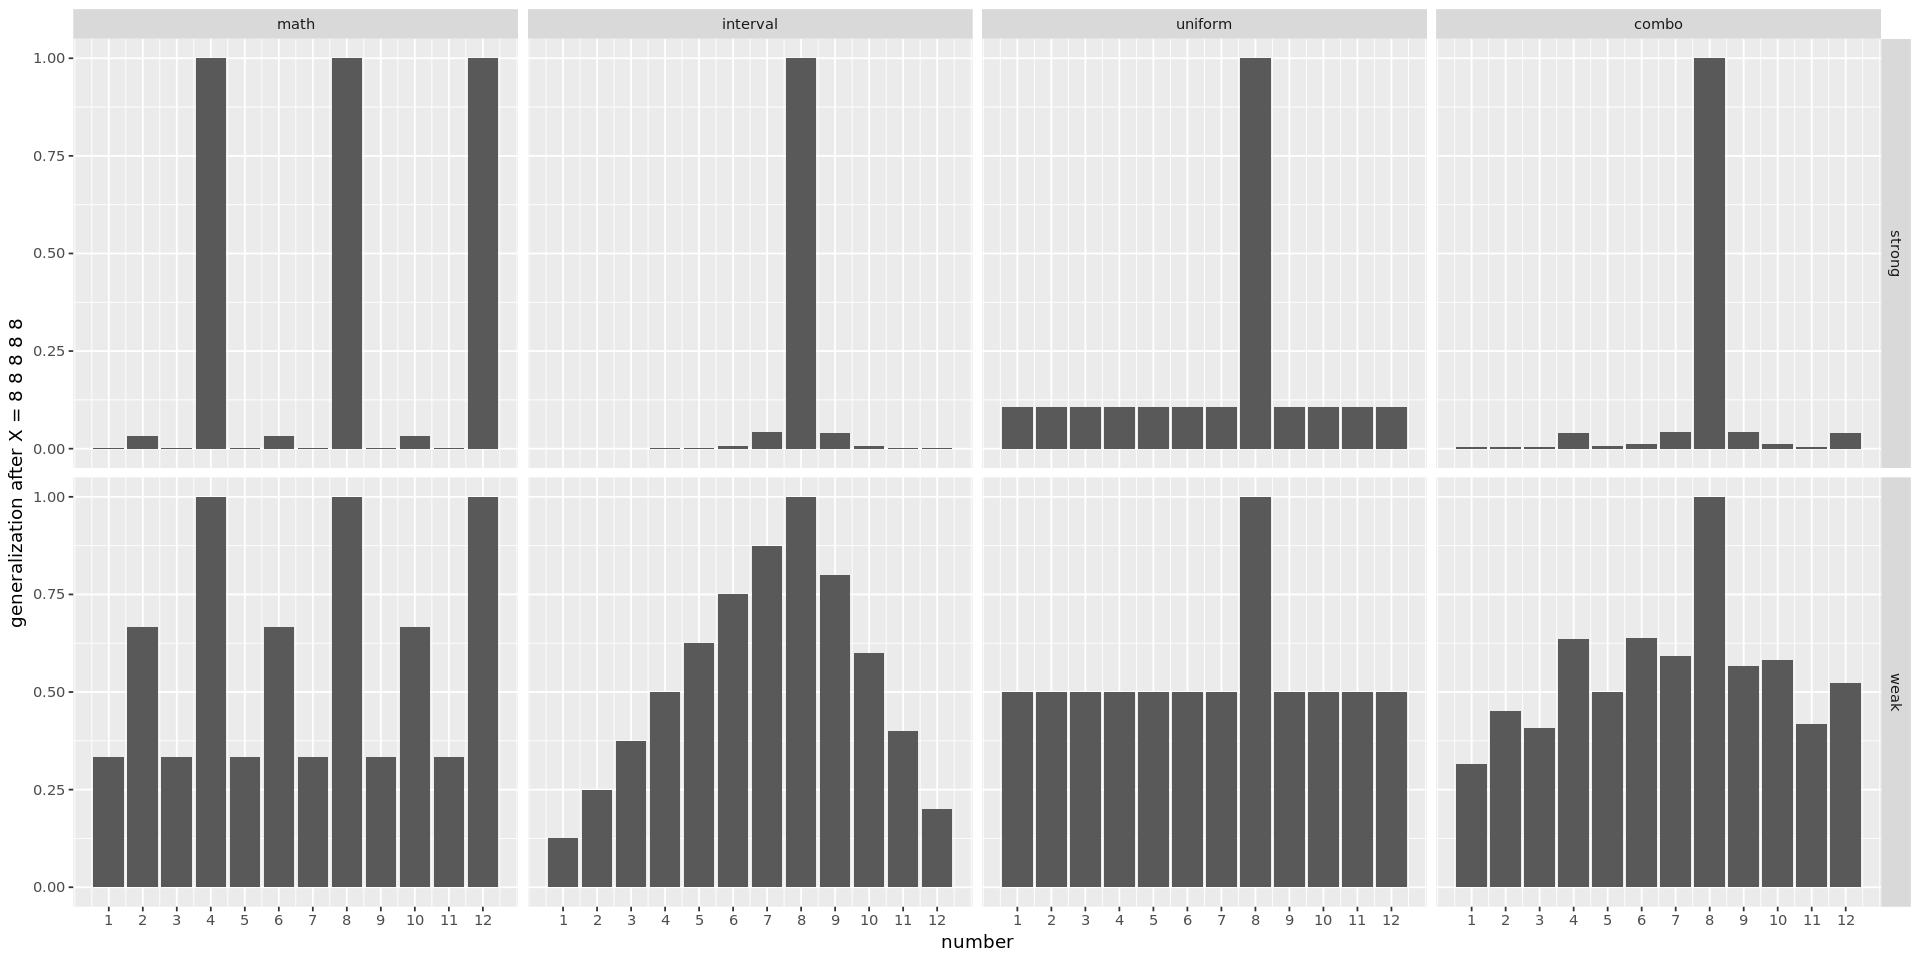

In [18]:
h_post <- number_game(h, c(8,8,8,8,8))

You should see that the predictive distributions in the top row (strong sampling) sharpen when a single positive example is repeated multiple times. For example, consider the `strong_combo` model. After observing 8 once, the model thinks that 4 is probably also a member of the concept, and the lowest prediction made for any number is just under 0.25. But after observing 8 a total of 5 times, the model is fairly sure that 8 is the *only* member of the concept -- the predictions for all other numbers are close to zero.

### Question 10 (1 point)

Your friend Eustace says that it doesn't make sense for a model to sharpen its predictions in this way. If $X = [8]$, you know that 8 belongs to the concept, and $X = [8,8,8,8,8]$ essentially gives you the same information --- both observation sets are really giving you one piece of information (ie that 8 belongs to the concept). Respond to Eustace and explain why it makes sense for a model to change its inferences as the same example is repeatedly observed.

=== BEGIN MARK SCHEME ===

Repeated observations are informative if the observations are randomly sampled from the concept. Imagine that you were drawing numbers from $C$ at random, and the number 8 came up 1000 times. By this stage you'd be almost certain that the $C$ included a single number only (ie 8). But if you drew a single 8, other possibilities are still viable -- the set could be even numbers, multiples of 4, numbers between 5 and 10, etc. 

=== END MARK SCHEME ===
